In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_Jun9_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
hists = {}
hists["Target_kaon_mass"] = hist.Hist("Target SP Kaons",
                                hist.Bin("m", r"Reconstructed Mass [MeV]", 80, 0, 1000),
                            ) 
hists["Target_pion_mass"] = hist.Hist("Target SP Kaons",
                                hist.Bin("m", r"Mass [MeV]", 80, 0, 300),
                            ) 

In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)

    target_kaon_dau1 = ldmx_events['TSP_Kaon_dau1']
    target_kaon_dau2 = ldmx_events['TSP_Kaon_dau2']
    target_kaon_dau3 = ldmx_events['TSP_Kaon_dau3']
    target_kaon_dau4 = ldmx_events['TSP_Kaon_dau4']
    
    kshort_pdgid = 310
    chargedpion_pdgid = 211
    
    # first select only events w 2 daughters
    mask_2dau = (target_kaon_dau2.gd==0)
    mask_4dau = (target_kaon_dau2.gd==1)
    
    kshort_mask = (abs(target_kaon_dau2.mompdgID)==kshort_pdgid)
    tp_mask_upper = (abs(target_kaon_dau2.z)<=30) 
    tp_mask_lower = (abs(target_kaon_dau2.z)>=25) 
        
    pidau2_mask = (abs(target_kaon_dau2.pdgID)==chargedpion_pdgid)

    pidau1 = get_vector(target_kaon_dau1[pidau2_mask & kshort_mask & mask_2dau & tp_mask_upper & tp_mask_lower])
    pidau2 = get_vector(target_kaon_dau2[pidau2_mask & kshort_mask & mask_2dau & tp_mask_upper & tp_mask_lower])

    pisum = (pidau1 + pidau2)
    
    print(flat(pidau1.mass).shape)
    print(flat(pidau2.mass).shape)
    print(flat(pisum.mass).shape)
    
    hists["Target_kaon_mass"].fill(      
                                 m=flat(pisum.mass),      
                                )
    hists["Target_pion_mass"].fill(      
                                 m=np.append(flat(pidau1.mass), flat(pidau2.mass)),      
                                )    
    
    return

In [6]:
nchunk = 0
for chunk in ldmx_dict:
    #if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
(35,)
(35,)
(35,)
process 2
(23,)
(23,)
(23,)
process 3
(35,)
(35,)
(35,)
process 4
(23,)
(23,)
(23,)
process 5
(40,)
(40,)
(40,)
process 6
(45,)
(45,)
(45,)
process 7
(28,)
(28,)
(28,)
process 8
(40,)
(40,)
(40,)
process 9
(43,)
(43,)
(43,)
process 10
(41,)
(41,)
(41,)
process 11
(32,)
(32,)
(32,)
process 12
(42,)
(42,)
(42,)
process 13
(36,)
(36,)
(36,)
process 14
(38,)
(38,)
(38,)
process 15
(32,)
(32,)
(32,)
process 16
(37,)
(37,)
(37,)
process 17
(31,)
(31,)
(31,)
process 18
(33,)
(33,)
(33,)
process 19
(35,)
(35,)
(35,)
process 20
(36,)
(36,)
(36,)
process 21
(35,)
(35,)
(35,)
process 22
(46,)
(46,)
(46,)
process 23
(42,)
(42,)
(42,)
process 24
(37,)
(37,)
(37,)
process 25
(39,)
(39,)
(39,)
process 26
(33,)
(33,)
(33,)
process 27
(36,)
(36,)
(36,)
process 28
(25,)
(25,)
(25,)
process 29
(31,)
(31,)
(31,)
process 30
(38,)
(38,)
(38,)
process 31
(43,)
(43,)
(43,)
process 32
(41,)
(41,)
(41,)
process 33
(31,)
(31,)
(31,)
process 34
(35,)
(35,)
(35,)
process 35
(40,)
(40,)


<Hist (m) instance at 0x12fa0f100>


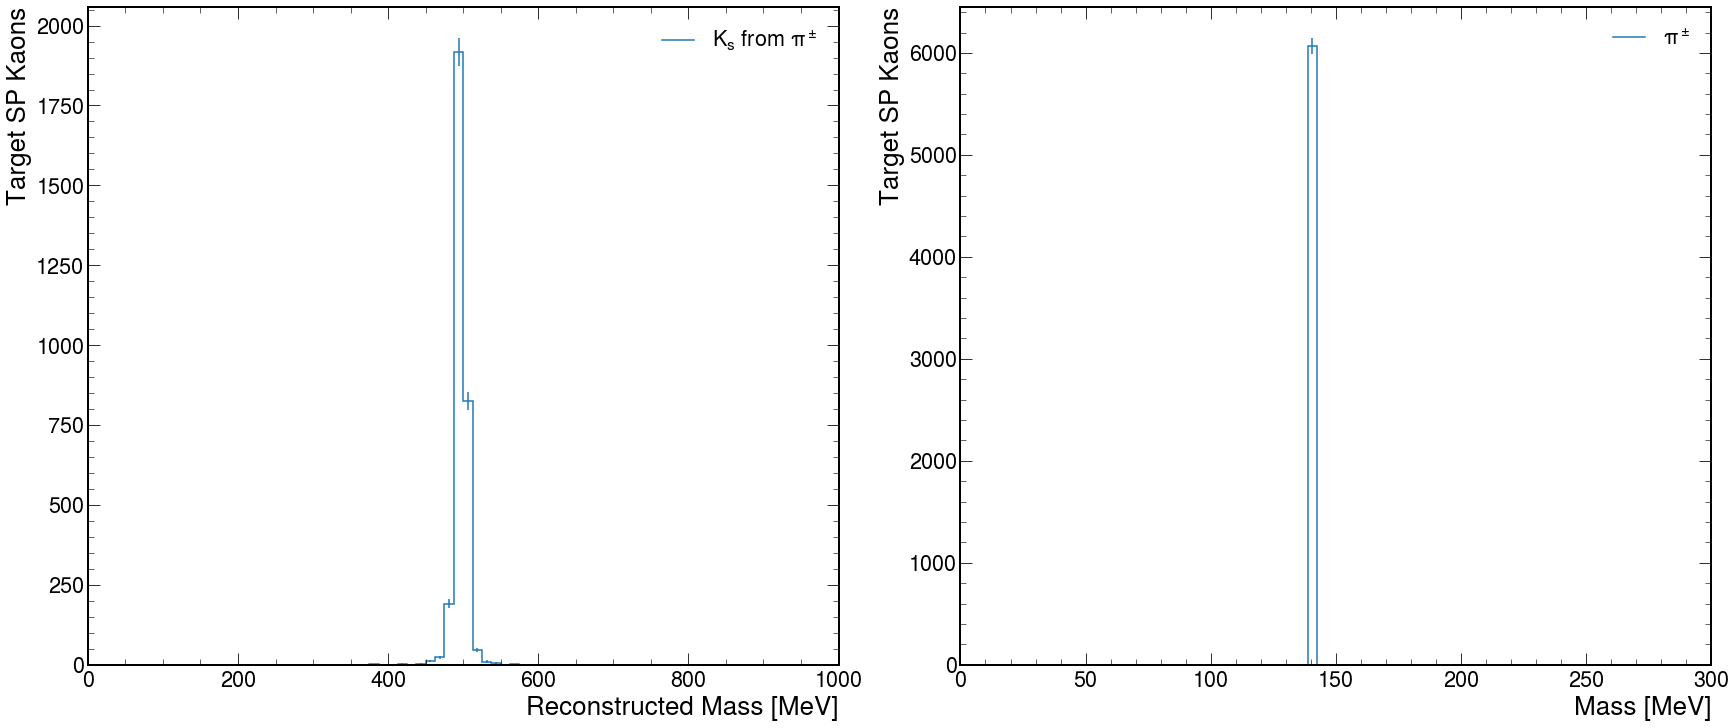

In [7]:
print(hists["Target_kaon_mass"])
fig, ax = plt.subplots(1,2,figsize=(24,10), constrained_layout=True)
hist.plot1d(hists["Target_kaon_mass"],ax=ax[0],clear=False);
leg = ax[0].legend([r'$K_s$ from $\pi^\pm$'])

hist.plot1d(hists["Target_pion_mass"],ax=ax[1],clear=False);
leg = ax[1].legend([r'$\pi^\pm$'])